In [1]:
import rpy2
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import scrublet as scr
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
deprecate                   0.3.2
en

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

# 1. Reading in the data

### **Prepare data**

Now, we load the preprocessed and annotated data for differential pathway analysis.

Make sure the anndata has the count data in either `.layers` or in `.X`. if count data is not in `.layers` it will be assumed that `.X ` contains the counts

In [4]:
adata_annot = sc.read_h5ad('../data/processed/adata_annotated.h5ad')
#adata_annot = sc.read_h5ad('../data/raw/leng_sfg/leng_sfg_filtered_anndata.h5ad')
adata_annot

AnnData object with n_obs × n_vars = 65619 × 16590
    obs: 'projid', 'fastq', 'Subject', 'sample', 'libraryid', 'study', 'age_death', 'educ', 'msex_x', 'gpath_x', 'amyloid_x', 'plaq_n_x', 'cogdx_x', 'pathologic diagnosis of AD', 'amyloid_y', 'plaq_n_y', 'nft', 'tangles', 'cogn_global_lv', 'gpath_y', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx_y', 'msex_y', 'pathology.group', 'sampleid', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Subject_colors', 'amyloid.group_colors', 'braaksc_colors', 'cell_type_colors', 'dendrogram_louvain_0.5', 'hvg', 'log1p', 'louvain', 'louvain_0.5_colors', 'louvain_1.0_colors', 'ms

Run the cell below to generate approciate `cell_type` column. 

`Note`: this should only be run if data does not contain appropriate cell-type notation in the form 
- `Excitatory`, `Inhibitory`, `Astrocyte`, `Oligodendrocyte`, `OPC`, `Microglia`, `Endothelial`.

In [5]:
get_cell_types = input('would you like to obtain appropriate cell-type columns: True/False')

Specify the way to map cells to appropriate cell-types

In [6]:
mapping = {'Exc': 'Excitatory', 'Inh': 'Inhibitory', 'Astro': 'Astrocyte',
           'Endo': 'Endothelial', 'Micro': 'Microglia', 'OPC': 'OPC', 'Oligo': 'Oligodendrocyte'}

In [7]:
if eval(get_cell_types.capitalize()):
    adata_annot.obs['cell_type'] = adata_annot.obs['clusterCellType'].map(mapping)

In [8]:
if 'counts' in adata_annot.layers.keys():
    print('normalizaing data using count data in .layers["counts] ')
    adata_annot.X = adata_annot.layers['counts'].toarray().copy()
    sc.pp.normalize_total(adata_annot, target_sum=1e04)
    sc.pp.log1p(adata_annot)
else:
    print('normaling data using count data in .X')
    adata_annot.layers['counts'] = adata_annot.X
    sc.pp.normalize_total(adata_annot, target_sum=1e04)
    sc.pp.log1p(adata_annot)

normalizaing data using count data in .layers["counts] 
normalizing counts per cell
    finished (0:00:00)


### **Prepare Meta-data**

Now we specify other related information

Specify the following:

- `metadata`: Path to metadata. Metadata must contain a column called `pathology.group` with the only unique groups being `no`, `early`, and `late`.

- `test_names`: List of the different test names of interest. This will only affect the tests that will be saved and not the overall linear model used in the design matrix itself as all contrasts (tests) will still be accounted for in the linear model.

- `control_group`: Name of control group in metadata. This should ideally be `no`, representing the control group 

- `subject_id`: Name of the column containing Subject/Patient ID in metadata and `.obs`

- `covariates`: This should be a list of additional confounding covariates (`not including pathology.group`) e.g `Sex`, `Sample Batch`, `Age` and other factors that might not be of interest but might have an effect on the pathological status. If you would not like to include any cofounders, please set `covaraites = ['None']`

- `save_prefix`: Prefix for saving critical files. preferably chosen to be in the format `{source name}_{brain region}`. e.g `mathys_pfc`
        

In [9]:
control_group = 'no' # name of the control group in metadata 
save_prefix = 'mathys_pfc'
covariates = ['msex_x']      # list of covariates to be accounted for in regression.
gene_celltype_threshold = 0.05 # determines number of cells the gene must be expressed in 
pathway_gene_threshold = 0.00 # determines number of genes that must be present in that pathway
subject_id = 'Subject' # for leng this is `PatientID` for mathys is 'Subject'
metadata = '../data/raw/mathys_pfc/mathys_pfc_metadata.csv'
test_names = ['early_vs_no', 'late_vs_early', 'ad_vs_no', 'late_vs_no']

## 2.4 Systematic differential analysis of pathway activity

Motivated by findings from [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), we perform differential pathway activity analysis using pathways obtained from the following databases (downloaded from the Mayaan laboratory; https://maayanlab.cloud/ Enrichr/#libraries):

- Gene Ontology biological processes (2018),
- KEGG (2019), 
- Reactome (2016) 
- and HumanCyc (2016) 


### Load and Process Pathways

In [10]:
def read_pathways(filename):
    with open(filename, 'r') as temp_f:
        col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]
    column_names = [i for i in range(0, max(col_count))]
    ### Read csv
    return pd.read_csv(filename, header=None, delimiter="\t", names=column_names)

bp = read_pathways('../data/pathway_databases/GO_Biological_Process_2018.txt')
cy = read_pathways('../data/pathway_databases/HumanCyc_2016.txt')
ke = read_pathways('../data/pathway_databases/KEGG_2019_Human.txt')
re = read_pathways('../data/pathway_databases/Reactome_2016.txt')

all_paths = pd.concat([bp, cy, ke, re], join='outer', axis=0, ignore_index=True)
all_paths.set_index(0, inplace=True)
all_paths.fillna("", inplace=True)
all_paths_dict = all_paths.to_dict(orient='index')


go_bp_paths = bp.set_index(0)
go_bp_paths.fillna("", inplace=True)
go_bp_paths_dict = go_bp_paths.to_dict(orient='index')


gene_set_by_path = {key: [val for val in value.values() if val != ""] for key, value in go_bp_paths_dict.items()}
gene_set_by_path = pd.DataFrame.from_dict(gene_set_by_path, orient='index').transpose()

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_2820/518703286.py:6: DtypeWarning: Columns (488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,7

### Expressed Genes Per cell-type

Next, we follow the protocol described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), and filter out genes not expressed in a significantly across a cell type. As in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), we retain genes that are expressed `in > 10%` of cells in that cell type using the gene counts stored in `.layers`


This filtereing is expected to minimize the discovery of false positive effects on pathway activity scores computed in a downstream step.

In [11]:

def filter_expressed_genes_by_celltype(adata: AnnData, 
                                      threshold: float=0.05):
    """

        Function to filter expressed genes by cell type based on a threshold

    """

    # Initialize empty dictionaries to store the expressed genes and gene sets per cell type
    expressed_genes_per_celltype = {}
    gene_set_per_celltype = {}

    # Loop through each unique cell type in the input AnnData object

    for cell_type in adata.obs.cell_type.unique():
        # Calculate the number of cells based on the specified threshold
        percent = threshold
        num_cells = round(percent*len(adata[adata.obs['cell_type']==cell_type]))
        
        adata_sub = adata[adata.obs.cell_type==cell_type].layers['counts']
        sc.pp.filter_genes(adata_sub, min_cells=1)
        detection_rate_threshold = 0.1
        gene_detection_rate = adata_sub.X.sum(axis=0) / adata_sub.obs['n_counts']
        gene_mask = gene_detection_rate >= detection_rate_threshold
        adata_filtered = adata_sub[:, gene_mask]


        # Filter genes based on minimum number of cells and store the resulting gene names
        # expressed_genes_per_celltype[cell_type], _ = sc.pp.filter_genes(adata[adata.obs.cell_type==cell_type].layers['counts'],
        #                                                                 min_cells=num_cells, inplace=False)
        # expressed_genes_per_celltype[cell_type] = list(adata.var_names[expressed_genes_per_celltype[cell_type]])

    # Convert the dictionary of expressed genes per cell type to a Pandas DataFrame
    expressed_genes_per_celltype = pd.DataFrame.from_dict(expressed_genes_per_celltype, orient='index').transpose()

    return expressed_genes_per_celltype


def filter_lowly_exp_genes(expressed: pd.DataFrame,
                           all_paths: pd.DataFrame,
                           threshold: float = 0.33):

    """

    Function to filter lowly expressed gene sets based on a threshold and pathway membership

    """                           
    # Initialize empty dictionaries to store the gene sets and gene sets per cell type
    gene_set = {}
    gene_set_per_celltype = {}

    # Loop through each cell type in the input Pandas DataFrame of expressed genes
    for cell_type in expressed.columns:
        # Determine which pathways have a proportion of genes above the specified threshold
        index = [sum(all_paths[x].isin(expressed[cell_type]))/len(all_paths[x]) > threshold for x in all_paths.columns]
        # Filter pathways based on threshold and store the resulting gene sets
        p = all_paths.loc[:, index]
        x = {y: pd.Series(list(set(expressed[cell_type]).intersection(set(p[y])))) for y in p.columns}
        x = {k: v for k, v in x.items() if not v.empty}
        gene_set[cell_type] = x

        # Convert the gene sets to Pandas DataFrames and store them in a dictionary by cell type
        gene_set_per_celltype[cell_type] = pd.DataFrame(columns=['description', 'member', 'name'])    
        for pathway, gene_list in gene_set[cell_type].items():

            df = pd.DataFrame(columns=['description', 'member', 'name'])  
            df['member'] = gene_list
            df['name'] = pathway
            df['description'] = pathway.split(" ")[-1]                                                          
            gene_set_per_celltype[cell_type] = pd.concat([gene_set_per_celltype[cell_type], df], join='outer', ignore_index=True)

        # Sort the resulting gene sets by description and member
        gene_set_per_celltype[cell_type].sort_index(axis=1, inplace=True)
        gene_set_per_celltype[cell_type].sort_index(axis=0, inplace=True)


    return gene_set_per_celltype

In [12]:
expressed_genes_per_celltype = filter_expressed_genes_by_celltype(adata_annot, threshold=gene_celltype_threshold)
gene_set_per_celltype = filter_lowly_exp_genes(expressed_genes_per_celltype, gene_set_by_path, threshold=pathway_gene_threshold)

filtered out 6744 genes that are detected in less than 1497 cells
filtered out 12485 genes that are detected in less than 976 cells
filtered out 8078 genes that are detected in less than 389 cells
filtered out 13621 genes that are detected in less than 98 cells
filtered out 10187 genes that are detected in less than 131 cells
filtered out 10894 genes that are detected in less than 174 cells
filtered out 11804 genes that are detected in less than 16 cells


UsageError: Cell magic `%%` not found.


### Aggregate Individual Level Averages Per cell-type

Next, we calculate individual-cell-type-level normalized gene expression profile averages that will be fed into the pathway analysis module.

In [13]:
def get_ind_level_ave(adata: AnnData, subject_id):
    """
    Get averaged expression data for each cell type and individual in an AnnData object.
    
    Args:
        adata (AnnData): An AnnData object with read counts (gene x cell).
        
    Returns:
        Dictionary: A dictionary of data frames with averaged expression data for each cell type and individual.
    """

    def sum_counts(counts, label, cell_labels, gene_labels):

        """
        Sums cell-level counts by factors in label vector.
        
        Args:
            counts (AnnData): An AnnData object with read counts (gene x cell).
            label (pd.DataFrame): Variable of interest by which to sum counts.
            cell_labels (pd.Index): Vector of cell labels.
            gene_labels (pd.Index): Vector of gene labels.
            
        Returns:
            Dictionary: A dictionary with the following keys:
                - 'summed_counts': A data frame with summed counts.
                - 'ncells': A data frame with the number of cells used per summation.
        """
        # Create a data frame with the label vector and add a column of 1s for counting.
        label_df = pd.DataFrame(label)
        label_df.columns = ['ID']
        label_df['index'] = 1

        # Add a column for cell type and pivot the data frame to create a matrix of counts.
        label_df['celltype'] = cell_labels
        label_df = label_df.pivot_table(index='celltype', columns='ID', values='index', aggfunc=np.sum, fill_value=0)
        label_df = label_df.astype(float)

        # Multiply the counts matrix by the gene expression matrix to get summed counts.
        summed_counts = pd.DataFrame(counts.X.T @ label_df.values, index = gene_labels, columns= label_df.columns)

        # Sum the number of cells used for each summation.
        ncells = label_df.sum()

        # Return the summed counts and number of cells as a dictionary.
        return {'summed_counts': summed_counts, 'ncells': ncells}
    
    # Get metadata from the AnnData object.
    meta = adata.obs # Get metadata


    # Create a data frame of labels by combining cell type and individual metadata fields.
    # Sum counts by individual
    labels = pd.DataFrame(meta['cell_type'].astype(str) + '_' + meta[subject_id].astype(str), columns=['individual'])

    # Sum counts by individual and store the results in a dictionary.
    summed_logcounts_cellxind = sum_counts(adata, labels, adata.obs_names, adata.var_names)

    # Calculate averages for each cell type and individual and store the results in a dictionary.
    # Get averages corresponding to both count matrices
    avs_logcounts = np.array(summed_logcounts_cellxind['summed_counts'].values) / np.array(summed_logcounts_cellxind['ncells'].values)
    avs_logcounts = pd.DataFrame(avs_logcounts, index = summed_logcounts_cellxind['summed_counts'].index,
                                            columns=summed_logcounts_cellxind['summed_counts'].columns)
    

    # Split the averages by cell type and individual and store the results in a dictionary.
    # Split column names into two parts: cell type and individual
    x = [col.split('_') for col in avs_logcounts.columns]
    celltype = [col[0] for col in x]
    individual = [col[1] for col in x]

    # Get unique cell types in the dataset
    celltype_unique = np.unique(celltype)

    # Create an empty dictionary to store the average counts for each cell type and individual    
    avs_by_ind_out = {}

    # Loop over the unique cell types and subset the average counts for each cell type and individual
    for i in celltype_unique:
        index = np.array(celltype)==i
        df = avs_logcounts.loc[:, index]
        df.columns = np.array(individual)[index]
        avs_by_ind_out[i] = df

    # Store the dictionary of average counts for each cell type and individual    
    avs_logcounts_cellxind = avs_by_ind_out
    # Return the dictionary of average counts for each cell type and individual
    return  avs_logcounts_cellxind



In [14]:
avs_logcounts_cellxind  = get_ind_level_ave(adata_annot, subject_id)

Now Let's confirm that the filtered data contains a reasonable proportion of AD risk genes reproted in previous literature

In [15]:
ad_genes = pd.read_csv('../data/pathway_databases/AD_genes.csv')

for cell_type in avs_logcounts_cellxind.keys():
    print(f'There are {sum(avs_logcounts_cellxind[cell_type].index.isin(ad_genes.Symbol))} AD-associated genes in {cell_type} cells')

There are 75 AD-associated genes in Astrocyte cells
There are 75 AD-associated genes in Endothelial cells
There are 75 AD-associated genes in Excitatory cells
There are 75 AD-associated genes in Inhibitory cells
There are 75 AD-associated genes in Microglia cells
There are 75 AD-associated genes in OPC cells
There are 75 AD-associated genes in Oligodendrocyte cells


### **Prep data for Gene Set Variation Analysis in R**

In [16]:

for cell_type in adata_annot.obs.cell_type.unique():
    prep_gsva(avs_logcounts_cellxind[cell_type], gene_set_per_celltype[cell_type], 
              tempdir=f'../results/gsva/{cell_type}/', verbose=False)

### Estimate Pathway Activity Scores

After estimating individual-cell-type-level normalized gene expression profile averages, we next calculated pathway activity scores, as described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w) and previously implemented in the R package (Gene Set Variational Analysis) GSVA (v.1.42.0)41. 

Briefly, GSVA estimates a normalized relative expression level per gene across samples. This expression level is then rank-ordered for each sample and aggregated into gene sets by calculating sample-wise enrichment scores using a Kolmogorov–Smirnov-like rank statistic.

As described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), we used the parameters to evaluate the 
GSVA function:

- `mx.diff=TRUE` 
- `kcdf=c("Gaussian")`
- `min.sz=5` 
- `max.sz=150`

The authors report that ...

`Activity scores computed this way accurately recovered cell type signatures that were not recovered by equally sized randomly sampled gene sets, suggesting that this approach captures transcriptomically encoded biological signals in snRNA-seq data`

In [17]:
%%R -o gsva_scores

library(GSEABase)
library(GSVA)
library(tidyr)
library(dplyr)

celltypes = c("Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC", "Endothelial")

# create an empty list to store the output for each celltype
gsva_scores = list()

# iterate over celltypes and perform gsva
for (celltype in celltypes) {
    # get gene sets
    geneSets = getGmt(file.path('../results/gsva/', celltype, 'gs.gmt'))
    geneSets = geneIds(geneSets)

    # read in expression data
    mat = as.matrix(read.csv(file.path('../results/gsva/', celltype, 'expr.csv'), header=TRUE, row.names=1, check.names=FALSE))
    
    # run gsva
    print(paste0("Estimating Pathway Activity Scores in ", celltype, " Cells"))
    print("........")
    exc_gsva = gsva(mat, geneSets, mx.diff=TRUE, kcdf=c("Gaussian"))
    
    # Convert matrix to data frame and gather into "long" format
    exc_gsva <- as.data.frame(exc_gsva, stringsAsFactors = FALSE)

    # store the output in a list
    gsva_scores[[celltype]] = exc_gsva

    write.csv(gsva_scores[[celltype]], file = file.path('../results/gsva/', celltype, 'gsva_scores.csv'))
}


[1] "Estimating Pathway Activity Scores in Excitatory Cells"
[1] "........"
Estimating GSVA scores for 5011 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Inhibitory Cells"
[1] "........"
Estimating GSVA scores for 4972 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Astrocyte Cells"
[1] "........"
Estimating GSVA scores for 4890 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Microglia Cells"
[1] "........"
Estimating GSVA scores for 4636 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Oli

### Differential pathway activity analysis

Next, for each pathway-cell type combination, pathway activity scores were modelled using a multivariate linear model as described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w):


`pathway activity ~ β0 × AD + β1 × msex + β2 × age_death.`

Here, AD is a binary variable, encoding the pathological status. Amyloid and nft are averages of continuous measurements of pathology, as evaluated and reported by ROSMAP. Age_death is a continuous measurement indicating age at death, pmi represents the PMI (a continuous measurement) and sex is a binary variable encoding biological sex.

`β0` represents the effect of AD on pathway activity, when accounting for confounding variables that might be correlated with, and therefore explain, a portion of the variation observed in the activity of a pathway of interest. 

The linear models were fitted using the lmfit() function and t-statistics were computed using the eBayes() function from the Limma R package (v.3.50.3). 

To prioritize candidate AD-dysregulated processes, pathways with snRNA-seq evidence of association with AD at a nominal P value of 0.05 are considered to be potential candidates. This procedure will result in prioritized candidate pathways for all cell types. 

The linear models were fitted using the lmfit() function and t-statistics were computed using the eBayes() function from the Limma R package (v.3.50.3).

In [18]:
%%R -o all_data -i control_group -i metadata -i subject_id -i covariates

library(limma)
library(magrittr)
library(tidyr)

####################################################################################################################
# Define function to get linear model fits for each gene set
get_fits = function(gsva_out, meta, covariates){
    fits = list()
    for(i in names(gsva_out)){
        # Get metadata for the samples corresponding to the gene set scores
        predict = meta[as.character(rownames(gsva_out[[i]])),]
        # Create a design matrix for the linear model with covariates

        # Define the formula based on the selected covariates

        covariate_list <- strsplit(covariates, " ")[[1]]
        if (covariate_list[1] == "None") {
            formula <- as.formula("~0 + pathology.group")
            }
        else {
            formula <- as.formula(paste0("~0 + ", paste(c("pathology.group", covariate_list), collapse = " + ")))
        } 
        # Generate the design matrix based on the formula and data
        mod <- model.matrix(formula, data = predict)


        #mod = model.matrix(~0 + pathology.group + SampleBatch, data=predict)
        contrasts <- makeContrasts(pathology.groupearly - pathology.groupno,
                                    pathology.grouplate - pathology.groupearly,
                                    pathology.grouplate - pathology.groupno,
                                    (pathology.groupearly + pathology.grouplate)/2 - pathology.groupno,
                                    levels=colnames(mod))
        # Fit the linear model using the gene set scores as the outcome
        fits[[i]] = fit.gsva(mod, i, gsva_out, 'pathology.group', contrasts)
    }
    return(fits)
}

####################################################################################################################
# Define function to fit linear models and get gene set scores for a single gene set
fit.gsva = function(mod1, i, gsva.per.celltype, coef, contrasts){
    # Fit the linear model with the gene set scores as the outcome
    allgenesets = list()
    fit <- lmFit(t(gsva.per.celltype[[i]]), design=mod1)
    fit <- contrasts.fit(fit, contrasts)
    # Use empirical Bayes to estimate variances and perform moderated t-tests
    fit <- eBayes(fit)
    
    # Extract all genesets, ranked by their P-values
    allgenesets[['early_vs_no']] <- topTable(fit, coef="pathology.groupearly - pathology.groupno", number=Inf, 
                                                confint = T) %>% .[order(.$P.Value, decreasing = F),]
    allgenesets[['late_vs_early']] <- topTable(fit, coef="pathology.grouplate - pathology.groupearly", number=Inf,
                                                confint = T) %>% .[order(.$P.Value, decreasing = F),] 
    allgenesets[['late_vs_no']] <- topTable(fit, coef="pathology.grouplate - pathology.groupno", number=Inf,
                                            confint = T) %>% .[order(.$P.Value, decreasing = F),]   
    allgenesets[['ad_vs_no']] <- topTable(fit, coef="(pathology.groupearly + pathology.grouplate)/2 - pathology.groupno", number=Inf,
                                            confint = T) %>% .[order(.$P.Value, decreasing = F),] 

    # allgenesets_2 <- topTable(fit, coef=2, number=Inf, confint = T) %>% .[order(.$P.Value, decreasing = F),]
    # Add the celltype and gene set names to the output table
    for(j in names(allgenesets)){
        allgenesets[[j]]$celltype = i
        allgenesets[[j]]$names = rownames(allgenesets[[j]])       
    }

    return(allgenesets)
}

####################################################################################################################
# Define function to get a data frame of gene set scores for all gene sets
get_scores = function(fits){
    outs = list()
    all = list()
    for(i in names(fits)){
        all[[i]] = list()
        for(j in names(fits[[i]])){
            # Extract gene set scores for a single gene set
            df = fits[[i]][[j]]
            # Add the celltype to the output table
            df$celltype = i
            # Sort the table by absolute log fold-change, in descending order
            df = df[order(abs(df$logFC),decreasing = T),]
            all[[i]][[j]] = df[,c('celltype', 'logFC','P.Value', 'names')]
        }
    }
    # Return a list containing the table of gene set scores for all gene sets
    return(list('all' = all))
}

####################################################################################################################
# Define function to get a matrix of gene set scores for the top gene sets, in a format suitable for heatmap plotting
get_matrix = function(scores, top_paths){
    # Combine the gene set scores for all gene sets into a single data frame
    df = do.call('rbind',scores)
    # Transform the scores into a matrix, with one row per gene set and one column per cell type
    df$score = sign(df$logFC) * -log10(df$P.Value)
    df = as.data.frame(pivot_wider(df[,c('celltype', 'names', 'score')], values_from = 'score', names_from = 'celltype'))
    # Replace missing values with 0
    df[is.na(df)] = 0
    # Use the gene set names as row names
    rownames(df) = df$names
    df$names = NULL
    return(df[top_paths,])
}

summary = read.csv(metadata)
#control_group = paste(control_group, 'pathology', sep='-')
summary$AD = ifelse(summary$pathology.group == control_group, 0, 1)
rownames(summary) = summary[, subject_id]


celltypes <- c("Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC", "Endothelial")

gsva_scores = list()
# iterate over celltypes and perform limma
for (celltype in celltypes) {

    # read in pathway scores
    pathway_scores = as.matrix(read.csv(file.path('../results/gsva/', celltype, 'gsva_scores.csv'), header=TRUE, row.names=1, check.names=FALSE))

    # store the output in a list
    gsva_scores[[celltype]] <- t(pathway_scores)
} 

all_data = list()

all_data[['gsva_out']] = gsva_scores

# get linear model fits
print('getting linear model fits...')
fits = get_fits(gsva_scores, summary, covariates)
all_data[['fits_all']] = fits

# get matrix of scores for heatmap
print('get matrix of scores')
scores = get_scores(fits)

# Create a new empty list to store the reorganized scores
new_scores <- list()

# Loop over the different tests
tests <- c("late_vs_early", "early_vs_no", "ad_vs_no", "late_vs_no")
for (test in tests) {
  
  # Create a new empty list for this test
  new_scores[[test]] <- list('all' = list())
  
  # Loop over the different cell types
  for (cell_type in celltypes) {
    
    # Copy the scores for this cell type and test
    new_scores[[test]][['all']][[cell_type]] <- scores[['all']][[cell_type]][[test]]
    
  }
}

# save new_scores in list
all_data[['scores_all']] = new_scores

print('filter by score 1.3')
# Extract unique gene names from scores object
all_data[['scores_filtered']] = list()
for(i in names(new_scores)){
    names = unique(unname(unlist(lapply(names(new_scores[[i]]$all), function(x) rownames(new_scores[[i]]$all[[x]])))))
    # Get a matrix of gene set scores for all samples
    mat = get_matrix(new_scores[[i]]$all, names)
    # Keep only rows with absolute values > 1.3 in at least one sample
    mat = mat[unname(rowSums(abs(mat)>1.3)>0),]

    # if(top_20==TRUE){
    #     index = unique(unname(unlist(lapply(colnames(mat), function(x) order(abs(mat[[x]]),decreasing = T)[1:20]))))
    #     mat = mat[index,]
    # }
    all_data[['scores_filtered']][[i]] = mat
}


[1] "getting linear model fits..."
[1] "get matrix of scores"
[1] "filter by score 1.3"


### Significant Pathway Selection

In [19]:
valid_pathways = {}
all_pathways = {}

for test_name in test_names:
    valid_pathways[test_name] = {}
    all_pathways[test_name] = pd.DataFrame()
    # Loop through each unique cell type in the cell_type column of adata_annot and filter statistically significant pathways
    for cell_type in adata_annot.obs.cell_type.unique():
        try:
            # Create a dataframe for the current cell type from a matrix in all_data, rename and set index.
            valid_pathways[test_name][cell_type] = pd.DataFrame(all_data['scores_filtered'][test_name][cell_type])
            all_data['scores_all'][test_name]['all'][cell_type].index.name = 'pathway'
            valid_pathways[test_name][cell_type].index.name = 'pathway'
            valid_pathways[test_name][cell_type].rename(columns={cell_type: 'score_adj'}, inplace=True)

            # Merge current cell type dataframe with its corresponding scores_all dataframe on "pathway" and remove missing rows
            valid_pathways[test_name][cell_type] = valid_pathways[test_name][cell_type].merge(all_data['scores_all'][test_name]['all'][cell_type],
                                                     how='outer', on='pathway')
            valid_pathways[test_name][cell_type].dropna(axis=0, inplace=True)

            # Filter rows with P.Value less than 0.05 from the current cell type dataframe and sort by P.Value    
            valid_pathways[test_name][cell_type] = valid_pathways[test_name][cell_type][valid_pathways[test_name][cell_type]['P.Value']<0.05]
            valid_pathways[test_name][cell_type].sort_values(by='P.Value', inplace=True)
            
            # Append the current cell type's dataframe to the all_pathways dataframe and sort by pathway
            all_pathways[test_name] = pd.concat([all_pathways[test_name], valid_pathways[test_name][cell_type]], axis=0)
            all_pathways[test_name].sort_values(by='pathway', inplace=True)
        except KeyError:
            continue

### Renaming convention

In [20]:
# Read in a CSV file containing the renaming convention for pathway names
# Remove duplicate names in the renaming convention dataframe
renaming_convention = pd.read_csv('../data/pathway_databases/renaming_convention.csv', dtype=str)
renaming_convention.drop_duplicates(subset='names', inplace=True)

for test_name in test_names:
    # Reset the index of the all_pathways dataframe to allow merging with renamed convention
    all_pathways[test_name].reset_index(inplace=True)
    all_pathways[test_name] = pd.merge(all_pathways[test_name], renaming_convention[['names', 'shortened', 'highlight']], how='left', on='names')
    all_pathways[test_name].set_index(keys='pathway', inplace=True)
    all_pathways[test_name] =  all_pathways[test_name].astype(object).replace(np.nan, 'None')

    # Write the all_pathways dataframe to a CSV file
    all_pathways[test_name].to_csv(f'../results/{test_name}/{save_prefix}_differentially_expressed_pathways.csv')

### Heat Map

In [21]:
def plot_and_select_top_deps(all_pathways, 
                            list_of_paths_to_annotate: list = [], 
                            save_name='cell_type_specific',
                            save_prefix: str = 'mathys_pfc', 
                            filter: bool=False,
                            cell_type_specific: bool = True,
                            test_name: str = ''): 

    if cell_type_specific:
        # Plot certain cell_type specific pathways 
        collated_df = pd.DataFrame(all_pathways.groupby(all_pathways.index).agg({'score_adj': list, 'celltype': list, 
                                    'logFC': list, 'P.Value': list, 'shortened': list, 'highlight': list}))
        # filter pathways only expressed in one cell type
        mask = collated_df["celltype"].apply(len) == 1
        df = collated_df[mask]

        # create pathway by cell type pivot table
        scores_table = pd.pivot_table(all_pathways, values='score_adj', index='pathway', columns='celltype')
        scores_table = scores_table.loc[df.index]
        scores_table['shortened'] = df.shortened.apply(lambda x: x[0])
        scores_table['highlight'] = df.highlight.apply(lambda x: x[0])
        scores_table.sort_values(by=[cell_type for cell_type in all_pathways.celltype.unique()], inplace=True)

        # drop pathways with same shortened names ??
        scores_table = scores_table.drop_duplicates(subset='shortened', keep='first')

        ###### Plot Cell type specific data

        if filter:
            xticks = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']

            fig, ax1 = plt.subplots(1, 1, figsize=(1, 6), sharex=False, layout='constrained')
            fig.tight_layout()

            # select only pathways that should be visualized
            shortened_names = scores_table[scores_table.shortened.isin(list_of_paths_to_annotate)]['shortened']
            scores_table = scores_table[scores_table.shortened.isin(list_of_paths_to_annotate)]
    
            # order table by cell type name
            # scores_table = scores_table.reindex(columns=['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte',
            #                                                     'OPC', 'Microglia'])
            scores_table = scores_table[xticks]

            g1 = sb.heatmap(scores_table, cmap='bwr', center=0, vmin=-2.5, vmax=2.5, robust=False, annot=None, fmt='.1g', 
                            linewidths=0.15, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.2},
                            cbar_ax=None, square=False,ax=ax1, xticklabels=xticks, yticklabels=shortened_names, mask=None,) 


            cax = g1.figure.axes[-1]

            g1.set_title(f'Select Cell-type-specific Pathways in {test_name.split("_")[0]}- vs {test_name.split("_")[-1]}-pathology',
                          fontsize=3)           
            g1.set_ylabel('')
            g1.set_xlabel('')

            ax1.tick_params(axis='both', which='major', labelsize=4, length=1.5, width=0.5)
            cax.tick_params(labelsize=4, length=1.5, width=0.5, which="major")

            plt.tight_layout()
            plt.savefig(f'../results/{test_name}/{save_prefix}_filtered_{save_name}_diff_exp_paths.pdf', bbox_inches='tight')
            plt.show(block=False)

        else:
            xticks = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia', 'Endothelial']

            fig, ax1 = plt.subplots(1, 1, figsize=(0.5, 6), sharex=False, layout='constrained')
            fig.tight_layout()

            scores_table = scores_table[scores_table.shortened!='None']     
            yticklabels = scores_table['shortened']
            # order table by cell type name
            
            scores_table = scores_table[xticks]

            g1 = sb.heatmap(scores_table, cmap='bwr', center=0, vmin=-2.5, vmax=2.5, robust=False, annot=None, fmt='.1g', 
                            linewidths=0.07, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.1},
                            cbar_ax=None, square=False, ax=ax1, xticklabels=xticks, yticklabels=yticklabels, mask=None,) 


            cax = g1.figure.axes[-1]

            g1.set_title(f'All Cell-type-specific Pathways in {test_name.split("_")[0]}- vs {test_name.split("_")[-1]}-pathology', 
                         fontsize=3)           
            g1.set_ylabel('')
            g1.set_xlabel('')

            ax1.tick_params(axis='both', which='major', labelsize=2, length=1.5, width=0.25)
            cax.tick_params(labelsize=4, length=1.5, width=0.25, which="major")

            plt.tight_layout()
            plt.savefig(f'../results/{test_name}/{save_prefix}_all_{save_name}_diff_exp_paths.pdf', bbox_inches='tight')
            plt.show(block=False)


    else:
        # Plot certain cell_type specific pathways 
        collated_df = pd.DataFrame(all_pathways.groupby(all_pathways.index).agg({'score_adj': list, 'celltype': list, 
                                    'logFC': list, 'P.Value': list, 'shortened': list, 'highlight': list}))
        # filte pathways only expressed in one cell type
        mask = collated_df["celltype"].apply(len) > 1
        df = collated_df[mask]

        # create pathway by cell type pivot table
        scores_table = pd.pivot_table(all_pathways, values='score_adj', index='pathway', columns='celltype')
        scores_table = scores_table.loc[df.index]
        scores_table['shortened'] = df.shortened.apply(lambda x: x[0])
        scores_table['highlight'] = df.highlight.apply(lambda x: x[0])
        scores_table.sort_values(by=[cell_type for cell_type in all_pathways.celltype.unique()], inplace=True)

        # drop pathways with same shortened names ??
        scores_table = scores_table.drop_duplicates(subset='shortened', keep='first')

        ###### Plot Cell type specific data

        if filter:
            xticks = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia', 'Endothelial']

            fig, ax1 = plt.subplots(1, 1, figsize=(1, 6), sharex=False, layout='constrained')
            fig.tight_layout()

            # select only pathways that should be visualized
            shortened_names = scores_table[scores_table.shortened.isin(list_of_paths_to_annotate)]['shortened']
            scores_table = scores_table[scores_table.shortened.isin(list_of_paths_to_annotate)]
        
            # order table by cell type name
            scores_table = scores_table[xticks]

            g1 = sb.heatmap(scores_table, cmap='bwr', center=0, vmin=-2.5, vmax=2.5, robust=False, annot=None, fmt='.1g', 
                            linewidths=0.15, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.2},
                            cbar_ax=None, square=False,ax=ax1, xticklabels=xticks, yticklabels=shortened_names, mask=None,) 

            cax = g1.figure.axes[-1]

            g1.set_title(f'Select Shared Pathways in {test_name.split("_")[0]}- vs {test_name.split("_")[-1]}-pathology', fontsize=3)           
            g1.set_ylabel('')
            g1.set_xlabel('')

            ax1.tick_params(axis='both', which='major', labelsize=4, length=1.5, width=0.5)
            cax.tick_params(labelsize=4, length=1.5, width=0.5, which="major")

            plt.tight_layout()
            plt.savefig(f'../results/{test_name}/{save_prefix}_filtered_{save_name}_diff_exp_paths.pdf', bbox_inches='tight')
            plt.show(block=False)

        else:
            xticks = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia', 'Endothelial']

            fig, ax1 = plt.subplots(1, 1, figsize=(0.5, 6), sharex=False, layout='constrained')
            fig.tight_layout()

            scores_table = scores_table[scores_table.shortened!='None']     
            yticklabels = scores_table['shortened']
            # order table by cell type name
            
            scores_table = scores_table[xticks]

            g1 = sb.heatmap(scores_table, cmap='bwr', center=0, vmin=-2.5, vmax=2.5, robust=False, annot=None, fmt='.1g', 
                            linewidths=0.07, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.1},
                            cbar_ax=None, square=False, ax=ax1, xticklabels=xticks, yticklabels=yticklabels, mask=None,) 

            cax = g1.figure.axes[-1]

            g1.set_title(f'All Broad Pathways in {test_name.split("_")[0]}- vs {test_name.split("_")[-1]}-pathology', fontsize=3)           
            g1.set_ylabel('')
            g1.set_xlabel('')

            ax1.tick_params(axis='both', which='major', labelsize=2, length=1.5, width=0.25)
            cax.tick_params(labelsize=4, length=1.5, width=0.25, which="major")

            plt.tight_layout()
            plt.savefig(f'../results/{test_name}/{save_prefix}_all_{save_name}_diff_exp_paths.pdf', bbox_inches='tight')
            plt.show(block=False)

    return 

Filtered Cell-type-specific Pathways

heatmap for select cell-type-specific pathways in early_vs_no test


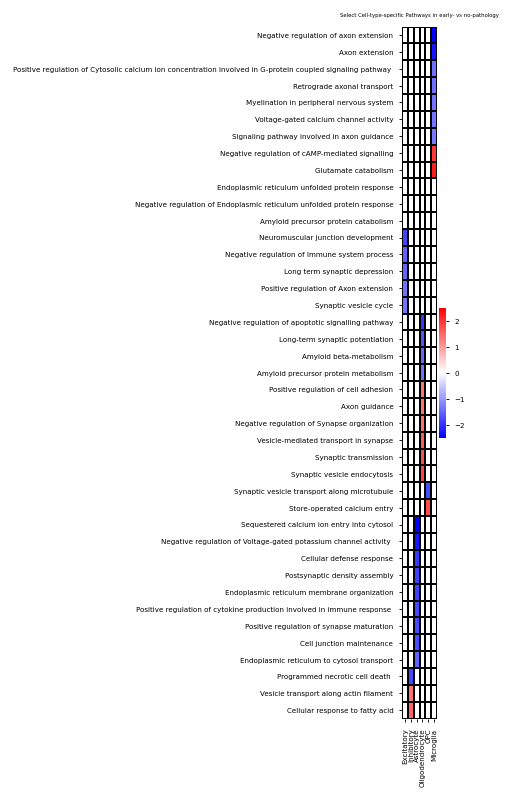

heatmap for select cell-type-specific pathways in late_vs_early test


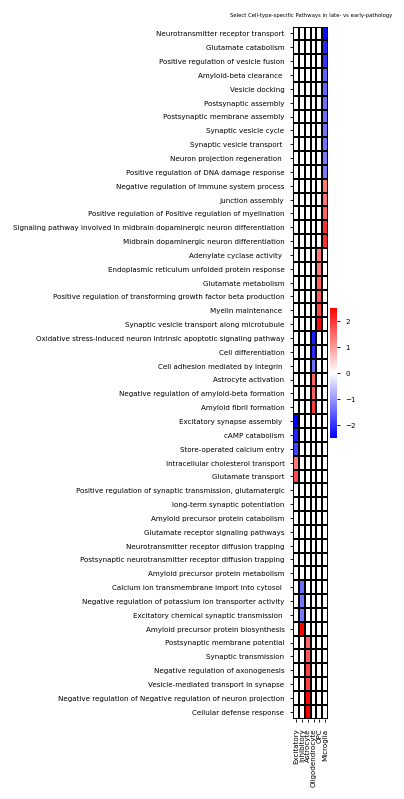

heatmap for select cell-type-specific pathways in ad_vs_no test


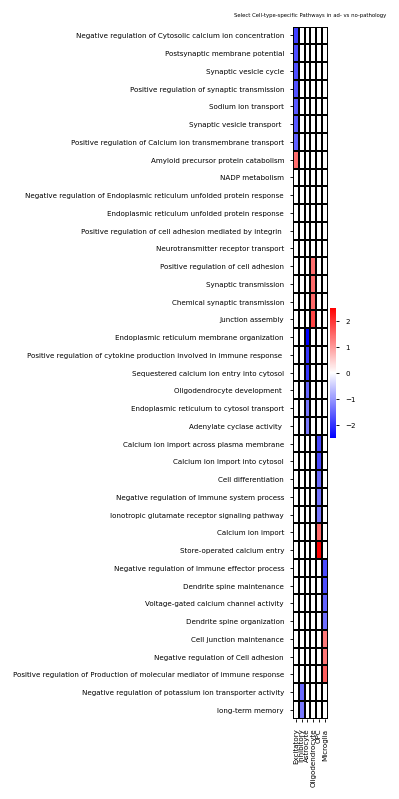

heatmap for select cell-type-specific pathways in late_vs_no test


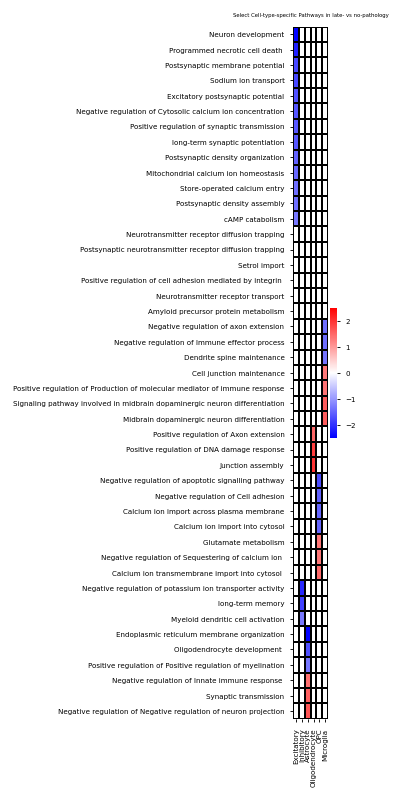

In [22]:
for test_name in test_names:
    print(f'heatmap for select cell-type-specific pathways in {test_name} test')
    list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
    plot_and_select_top_deps(all_pathways[test_name], list_of_paths_to_annotate, save_prefix=save_prefix,
                         save_name='cell_type_specific', filter=True, cell_type_specific=True, 
                         test_name=test_name)

All Cell-type-specific Pathways

heatmap for all cell-type-specific pathways in early_vs_no test


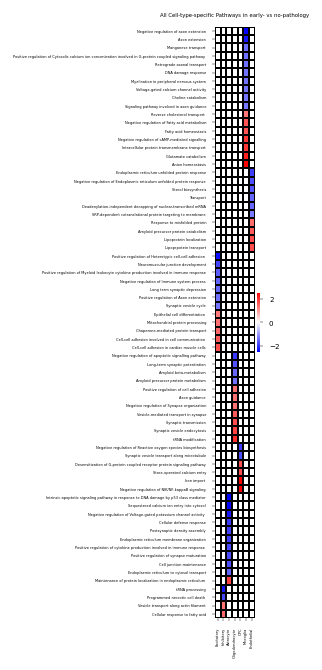

heatmap for all cell-type-specific pathways in late_vs_early test


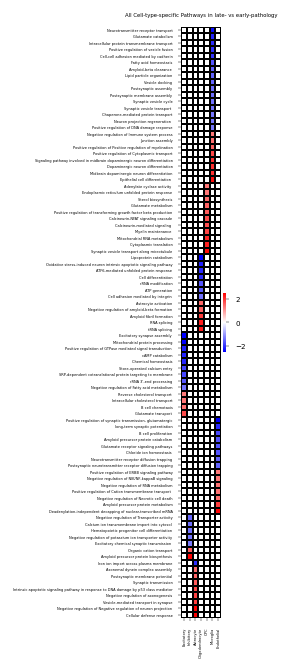

heatmap for all cell-type-specific pathways in ad_vs_no test


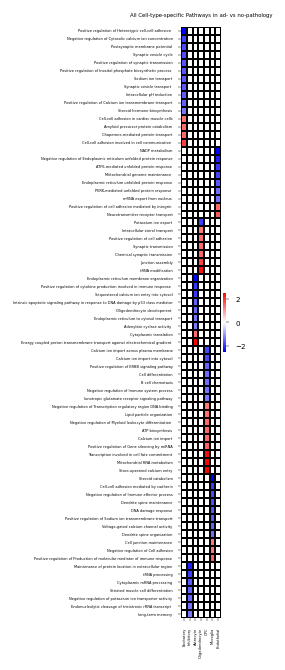

heatmap for all cell-type-specific pathways in late_vs_no test


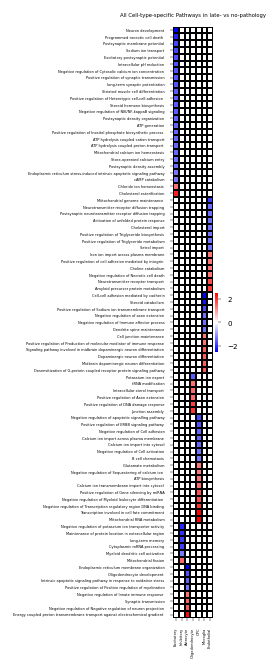

In [23]:
for test_name in test_names:
    print(f'heatmap for all cell-type-specific pathways in {test_name} test')
    list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
    plot_and_select_top_deps(all_pathways[test_name], list_of_paths_to_annotate, save_prefix=save_prefix,
                         save_name='cell_type_specific', filter=False, cell_type_specific=True, 
                         test_name=test_name)


Filtered Shared Pathways

heatmap for select shared pathways in early_vs_no test


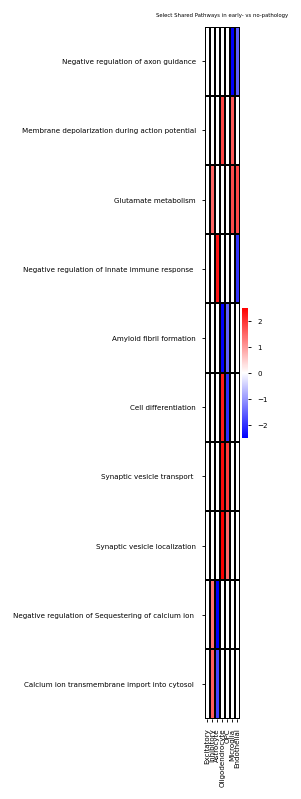

heatmap for select shared pathways in late_vs_early test


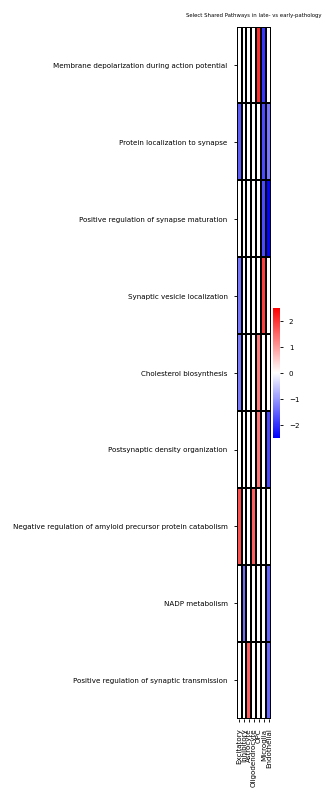

heatmap for select shared pathways in ad_vs_no test


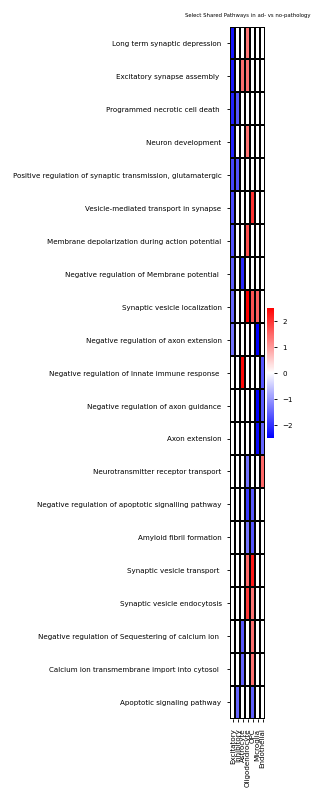

heatmap for select shared pathways in late_vs_no test


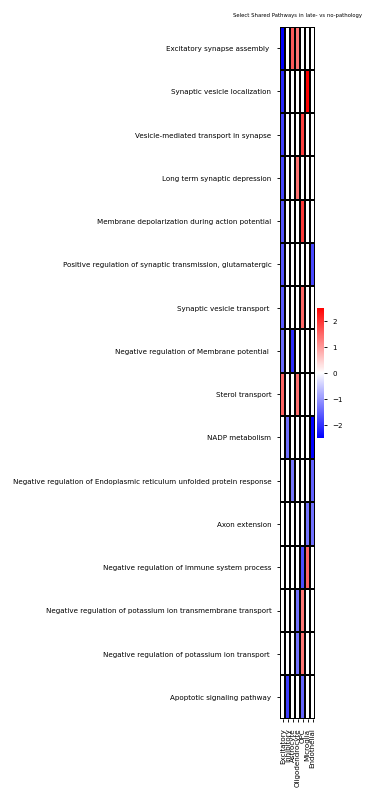

In [24]:
for test_name in test_names:
    print(f'heatmap for select shared pathways in {test_name} test')
    list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
    plot_and_select_top_deps(all_pathways[test_name], list_of_paths_to_annotate, save_prefix=save_prefix,
                         save_name='broad', filter=True, cell_type_specific=False, 
                         test_name=test_name)


All shared Pathways

heatmap for all shared pathways in early_vs_no test


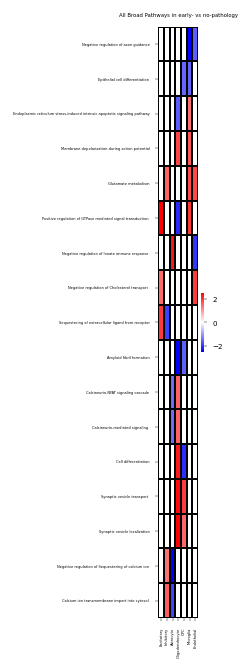

heatmap for all shared pathways in late_vs_early test


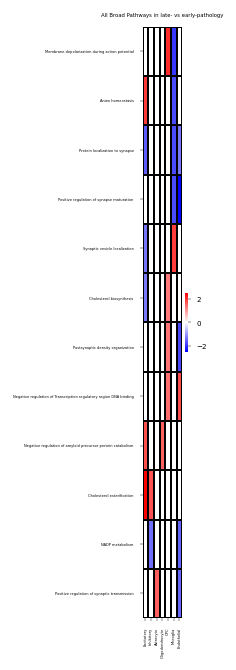

heatmap for all shared pathways in ad_vs_no test


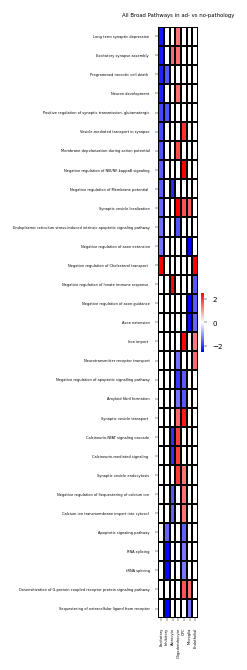

heatmap for all shared pathways in late_vs_no test


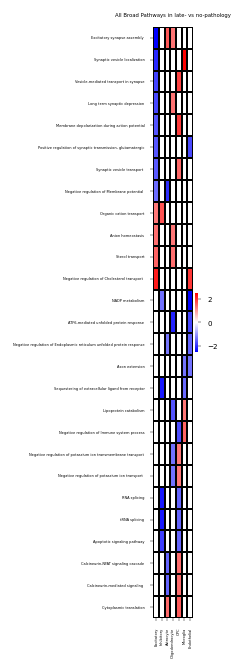

In [25]:
for test_name in test_names:
    print(f'heatmap for all shared pathways in {test_name} test')
    list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
    plot_and_select_top_deps(all_pathways[test_name], list_of_paths_to_annotate, save_prefix=save_prefix,
                         save_name='broad', filter=False, cell_type_specific=False, 
                         test_name=test_name)
    